## LDA y árboles de decisión

***

**1.** Se importan las librerías *pandas* y funciones de *sklearn.model_selection* para cargar el archivo de la base de datos, así como para separar los datos de entrenamiento y prueba. 

En este caso se hace una separación 70/30 cuidando mantener un balance de clases. Se utiliza *Dropped_Out* como criterio de estratificación para asegurar que la proporción de clases en ambos conjuntos sea similar. Para demostrar que se cumplió la condición se imprimen datos relevantes del archivo.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

data=pd.read_csv('students.csv')
print(data.head(10))

train_data,test_data=train_test_split(data,test_size=0.3,stratify=data["Dropped_Out"],random_state=42)
total=train_data.shape[0]+test_data.shape[0]

print("Dimensiones del data frame:",data.shape)
print("Observaciones datos de entrenamiento:",train_data.shape)
print("Observaciones datos de prueba:",test_data.shape)
print("Cantidad de observaciones totales:",total)

  School Gender  Age Address Family_Size Parental_Status  Mother_Education  \
0     GP      F   18       U         GT3               A                 4   
1     GP      F   17       U         GT3               T                 1   
2     GP      F   15       U         LE3               T                 1   
3     GP      F   15       U         GT3               T                 4   
4     GP      F   16       U         GT3               T                 3   
5     GP      M   16       U         LE3               T                 4   
6     GP      M   16       U         LE3               T                 2   
7     GP      F   17       U         GT3               A                 4   
8     GP      M   15       U         LE3               A                 3   
9     GP      M   15       U         GT3               T                 3   

   Father_Education Mother_Job Father_Job  ... Free_Time Going_Out  \
0                 4    at_home    teacher  ...         3         4   
1

***

**2.** Se importa *statsmodels.api*. 
Debido a que se trabajará con un modelo de regresión logística simple con la función modelos lineales generalizados (GLM) así como LDA, se seleccionan las variables numéricas de la base de datos y elimina la variable objetivo. Ya que se tienen tienen las variables a utilizar, se definen las variables predictoras y objetivo.

Se ajusta un modelo de regresión y se utiliza el parámetro *sm.families.Binomial* ya que este indica que el modelo de regresión sigue una distribución binomial. La regresión es un caso de modelos GLM donde la variable dependiente es binaria (valores de 0 o 1). En este caso *Binomial()* indica que los valores de *Dropped_Out* son de tipo binario (1= abandonó, 0= no abandonó), y se ajusta un modelo logístico para predecir la probabilidad de que un estudiante abandone.

Con base a la información obtenida en el resumen del modelo, se seleccionan las dos variables más relevantes para los modelos posteriores a realizar y se eliminan todas las demás variables de los datos de entrenamiento y prueba. 

Al momento de la selección de las dos variables se toma en consideración el valor P>|z| que sea <0.05 para corroborar que este relacionado a la variable de salida, seleccionando *final grade*. Para *grade 2* aunque no tiene un valor z<0.05 considere seleccionarla para evaluar cómo las últimas dos evaluaciones afectan la probabilidad de abandono.

In [7]:
import statsmodels.api as sm

num=data.select_dtypes(include=['int64']).columns.drop("Dropped_Out")

X_train=train_data[num]
y_train=train_data["Dropped_Out"]
X_train=sm.add_constant(X_train)

logit_model=sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
print(logit_model.summary())

selected=["Final_Grade", "Grade_2"]
X_train_selected, X_test_selected=train_data[selected], test_data[selected]
y_train_selected, y_test_selected=train_data["Dropped_Out"], test_data["Dropped_Out"]

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Dropped_Out   No. Observations:                  454
Model:                            GLM   Df Residuals:                      437
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9.2740
Date:                Thu, 20 Mar 2025   Deviance:                       18.548
Time:                        11:16:03   Pearson chi2:                     400.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.5558
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

***

**3.** Se importan las funciones *StandarScaler*, *LinearDiscriminantAnalysis*, así como las librerías *matplotlib.pyplot* y *seaborn*.

Antes de aplicar LDA se estandarizan las variables. Esto se refiere a transformar la media y desviación estándar de los datos de entrenamiento y prueba a 0 (la media) y 1 (la desviación). Posterior a esto se muestran las probabilidades a priori para LDA, esto para calcular la probabilidad posterior de que un estudiante abandone, dada su información.

Para una mejor visualización de los datos se grafican ambas variables seleccionadas con Kernel Density Estimation (KDE) para representar la densidad de los datos, en este caso *Final grade* y *Grade 2*. En estas dos gráficas se observa que los estudiantes que no abandonaron tienen calificaciones entre 10 y 20, a diferencia de los que abandonaron con 0 y 10. Se observa que en ambos casos existe una superposición, sin embargo hay una tendencia clara de los que abandonaron tienen, en promedio calificaciones más bajas. Con esto se reafirma la selección de estas dos variables como relevantes puesto que a pesar de las limitaciones por el solapamiento, son buenas predictoras.

Se genera un modelo utilizando la metodología de análisis discriminante lineal y visualizan los resultados con un diagrama de dispersión. Al graficar Final grade vs Grade 2, se observa que ambas variables pueden aportar información al modelo puesto existe una separación entre ambos grupos, considerando que por sí solas no son suficientes para predecir con precisión la deserción.

Probabilidades a priori:
Dropped_Out
0    0.848018
1    0.151982
Name: proportion, dtype: float64


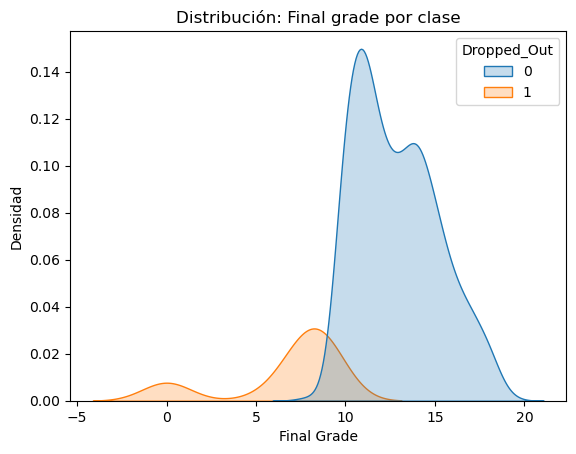

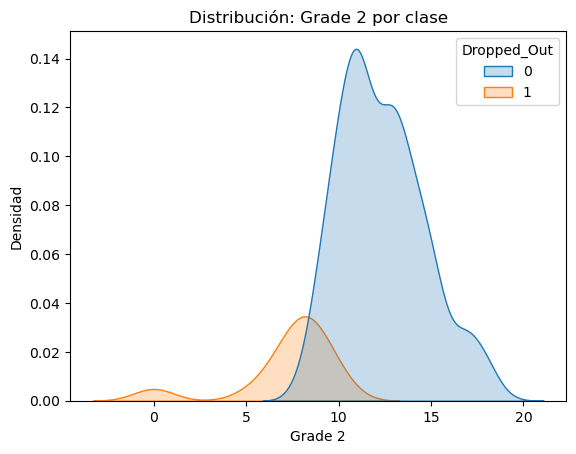

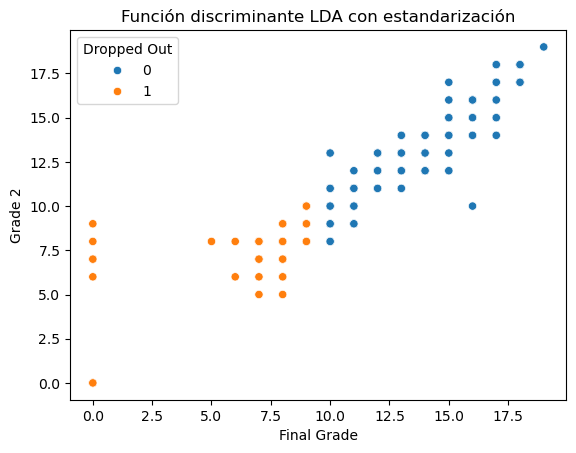

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

scaler=StandardScaler()
X_train_selected_scaled=scaler.fit_transform(X_train_selected)
X_test_selected_scaled=scaler.transform(X_test_selected)

prior=y_train_selected.value_counts(normalize=True)
print("Probabilidades a priori:")
print(prior)

sns.kdeplot(data=train_data,x="Final_Grade",hue="Dropped_Out",fill=True)
plt.title("Distribución: Final grade por clase")
plt.xlabel("Final Grade")
plt.ylabel("Densidad")
plt.show()

sns.kdeplot(data=train_data,x="Grade_2",hue="Dropped_Out",fill=True)
plt.title("Distribución: Grade 2 por clase")
plt.xlabel("Grade 2")
plt.ylabel("Densidad")
plt.show()

lda=LDA()
lda.fit(X_train_selected_scaled, y_train_selected)
lda_values=lda.transform(X_train_selected_scaled)

sns.scatterplot(data=train_data,x="Final_Grade",y="Grade_2",hue="Dropped_Out")
plt.title("Función discriminante LDA con estandarización")
plt.xlabel("Final Grade")
plt.ylabel("Grade 2")
plt.legend(title="Dropped Out")
plt.show()

***

**4.** Se importa la librería *numpy* y función *DecisionTreeClassifier*. 

Se define una lista de valores de alpha, que es el parámetro de poda. Se prueban los valores de alpha en validación cruzada siendo, una metodología de LOOCV, para encontrar cúal produce el mejor desempeño. Esto significa que se entrena y evalúa el modelo con validación cruzada y se obtiene el desempeño promedio en todas las particiones, guardando el resultado en *scores*. 

Utlizando *np.argmax(scores)* se selecciona el primer valor de alpha que se encuentra con el score máximo. Este alpha será de utilidad para la poda del árbol. Se prueban 3 valores distintos de alpha con 10 folds y evalua cual de estos es el más adecuado de todos. 

Teniendo el valor de alpha óptimo se genera y entrena el árbol podado para posteriormente visualizar el resultado final. Es relevante mencionar que para controlar la poda del árbol se utiliza *ccp_alpha* lo cual conlleva el método de Cost Complexity Pruning, donde mayor sea *ccp_alpha*, más nodos se eliminarán, generando un árbol más simple, por lo que si llega a valer cero no se haría poda y el árbol se expandería por completo.  

Respecto al resultado del árbol de decisión, en la parte del nodo raíz se tiene como condición *Final grade* <= 9.5 con un índice gini indicando cierto grado de impureza, 385 estudianres que no abandonaron y 69 que sí abandonaron. Para la división de los dos nodos, del del lado izquierdo tiene un índice gini muy bajo, indicando que casi todos los ejemplos pertenecen a la clase de los que sí abandonaron (69 estudiantes), con esto es posible decir que si un estudiante tiene un final grade <= 9.5 es casi seguro que abandonará (69 de 70 lo hicieron). Por el del lado derecho, hay un índice gini de cero, indicando que todos pertenecen a los que no abandonaron, por lo que si un estudiante tiene *final grade* mayor a 9.5 es seguro que no abandonará.

Solamente se usa la variable *Final grade* puesto que el árbol indica que está es más fuerte para predecir la deserción, si una variable ya es suficiente para dividir correctamente las clases, el árbol no requiere más divisiones.

Mejor valor de alpha seleccionado: 0.1


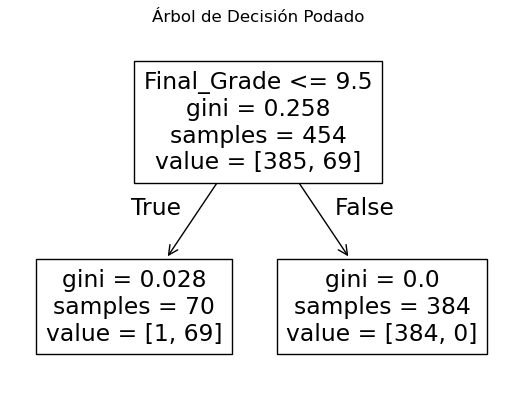

In [13]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree

alphas=[0.1, 0.15, 0.2]  
kf=StratifiedKFold(n_splits=10)

scores=[cross_val_score(DTC(ccp_alpha=alpha), X_train_selected, y_train_selected, cv=kf).mean() for alpha in alphas]

best_alpha=alphas[np.argmax(scores)]
print(f"Mejor valor de alpha seleccionado: {best_alpha}")

pruned_tree=DTC(ccp_alpha=best_alpha).fit(X_train_selected, y_train_selected)

plot_tree(pruned_tree, feature_names=X_train_selected.columns)
plt.title("Árbol de Decisión Podado")
plt.show()

***

**5.** Se importan las funciones *accuracy_score*, *precision_score*, *recall_score*, *f1_score*, *confusion_matrix* para evaluar las métricas tanto de LDA y el árbol de decisión. 

Para la construcción de la matriz de confusión de cada uno de los modelos, se extraen los valores para generar los verdaderos negativos (TN), falsos positivos (FP), falsos negativos (FN), y verdaderos positivos (TP). 

Para ambos modelos se calculan las siguientes métricas: especificidad, precisión, accuracy, sensibilidad y f1 score.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

lda_preds=lda.predict(X_test_selected_scaled)
tree_preds=pruned_tree.predict(X_test_selected)

lda_cm=confusion_matrix(y_test_selected, lda_preds)

lda_tn=lda_cm[0, 0]  
lda_fp=lda_cm[0, 1]  
lda_fn=lda_cm[1, 0]  
lda_tp=lda_cm[1, 1]  
lda_specificity=lda_tn/(lda_tn+lda_fp)
print("Modelo LDA")
print("Exactitud (accuracy):", accuracy_score(y_test_selected, lda_preds))
print("Precision:", precision_score(y_test_selected, lda_preds))
print("Sensibilidad:", recall_score(y_test_selected, lda_preds))
print("F1-Score:", f1_score(y_test_selected, lda_preds))
print("Especificidad:", lda_specificity)
print("Matriz de Confusión:\n", lda_cm)
print("")

tree_cm=confusion_matrix(y_test_selected, tree_preds)

tree_tn=tree_cm[0, 0]  
tree_fp=tree_cm[0, 1]  
tree_fn=tree_cm[1, 0] 
tree_tp=tree_cm[1, 1]
tree_specificity=tree_tn/(tree_tn + tree_fp)
print("Modelo Árbol de Decisión")
print("Exacttud (accuracy):", accuracy_score(y_test_selected, tree_preds))
print("Precision:", precision_score(y_test_selected, tree_preds))
print("Sensibilidad:", recall_score(y_test_selected, tree_preds))
print("F1-Score:", f1_score(y_test_selected, tree_preds))
print("Especificidad:", tree_specificity)
print("Matriz de Confusión:\n", tree_cm)

Modelo LDA
Exactitud (accuracy): 0.9025641025641026
Precision: 0.9166666666666666
Sensibilidad: 0.3793103448275862
F1-Score: 0.5365853658536586
Especificidad: 0.9939759036144579
Matriz de Confusión:
 [[165   1]
 [ 18  11]]

Modelo Árbol de Decisión
Exacttud (accuracy): 0.9948717948717949
Precision: 0.9666666666666667
Sensibilidad: 1.0
F1-Score: 0.9830508474576272
Especificidad: 0.9939759036144579
Matriz de Confusión:
 [[165   1]
 [  0  29]]


***

**Conclusión** 

Con base a los modelos obtenidos específicamente para este trabajo, se logra identificar diferencias en las métricas calculadas para cada uno de estos. 

- Exactitud (Accuracy): el árbol de decisión tiene mejor exactitud (99.48%) que el LDA (90.26%), clasificando correctamente más observaciones en total.
- Precisión: el árbol de decisión tiene mejor precisión (96.67%) que el LDA (91.67%), indicando que hace menos falsas alarmas.
- Sensibilidad: el árbol de decisión tiene una sensibilidad más alta (100%) que el LDA (37.93%). En este métrica es la que más diferencia hay entre un modelo y otro, y esto se debe a que se mide cuántos de los casos positivos reales fueron correctamente identificados por el modelo. En el caso del LDA estudiantes que realmente abandonaron son clasificados erróneamente como no abandono, aumentando los falsos negativos.
- F1-score: el árbol de decisión es mejor (98.3%) que el LDA (53.65%). Al estar relacionado con la sensibilidad, (esta métrica es el equilibrio entre precisión y sensibilidad) el f1 score del LDA se ve directamente afectado.
- Especificidad: ambos tienen la misma especificidad con 99.39%.

En cuanto a la matriz de confusión, el árbol de decisión detecta correctamente a los 29 estudiantes que abandonaron (TP) con 0 FN, mientras que LDA solo detecta 11 (TP) con 18 FN. En este caso se ve que LDA pierde 18 estudiantes que sí abandonaron.

Debido a que en todas las métricas evaluadas el árbol de decisión tiene resultados más altos, para este caso en específico, el mejor modelo es el árbol de decisión. Al ser todas las métricas altas, surge una gran sospecha de sobre ajuste, sin embargo es posible observar que la profundidad del árbol ni el número de hojas es grande, por lo que debido a que el árbol es simple parece ser muy efectivo. No obstante es relevante buscar considerar otros factores para tener una predicción más completa.